# Chapter 7 RNN을 사용한 문장 생성

1. 말뭉치
2. 개선된 언어 모델
3. seq2seq

## 7.1 언어 모델을 사용한 문장 생성

### 7.1.1 RNN을 사용한 문장 생성의 순서

언어 모델 - 단어의 확률 분포 출력  

#### 단어의 확률 분포를 이용해서 다음 단어를 새로 생성하는 방법
1. 결정적 방법  
확률이 가장 높은 단어를 출력, 매번 동일한 단어를 생성

2. 확률적 방법  
단어의 확률 분포를 기반으로 단어를 샘플링, 매번 선택되는 단어가 달라짐

생성된 단어를 언어 모델에 입력해서 원하는 만큼 반복하면서 단어를 계속 생성한다.

### 7.1.2 문장 생성 구현

In [5]:
# Rnnlm 클래스를 상속해 RnnlmGen 클래스를 만든다.
import numpy as np
from common.functions import softmax
from rnnlm import Rnnlm
from better_rnnlm import BetterRnnlm

In [6]:
class RnnlmGen(Rnnlm):
    
    def generate(self, start_id, skip_ids=None, sample_size=100):
        ''' 언어 모델을 통해 문장을 생성하는 메소드
        
        Parameters
        ----------
        start_id: 최초로 주어지는 단어 ID
        skip_id: 샘플링되지 않게 할 단어 리스트(PTB 데이터셋의 <unk>나 N 등 전처리된 단어를 샘플링하지 않도록)
        sample_size: 샘플링하는 단어 수 
        
        Return
        ----------
        word_ids: 생성된 단어 ID 리스트
        '''
        
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)    # 미니배치로 처리하기 때문에 2차원 배열이어야 함
            score = self.predict(x)
            p = softmax(score.flatten())
            
            sampled = np.random.choice(len(p), size=1, p=p)
            if(skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
                
        return word_ids

In [7]:
# 학습 없이 단어를 생성
from rnnlm_gen import RnnlmGen
from dataset import ptb

In [8]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('Rnnlm.pkl')

# 시작 문자와 건너뜀 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you had begun to sustain a revised offer mr. lawson 's history.
 but it 's why no like poison kong society barbara.
 mr. lawson the arco will professionals only at least once consider the baltimore education line next fall.
 we did i am not let i think.
 we wonder whether a few years we 'll be organized was.
 i 'm unlikely.
 president bush feels whether nothing remains there collapse.
 investment executives fails to live in the last eight sound out of when though a second part could form technique diplomats c.d.s eligible for


모델을 학습시키기 전 문장 생성을 하면 단어를 엉터리로 나열할 뿐이다.

모델을 학습시키고 그 가중치를 이용해서 문장을 생성하면 그럴듯한 문장이 만들어진다. 의미적으로나 문법적으로 완벽한 문장도 있지만 약간 문제가 있는 문장이 뒤섞여 있다.

### 7.1.3 더 좋은 문장으로

In [9]:
# coding: utf-8
from common.np import *
from rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)

you handles a lot of money on a truly explanation says guy a specialist in the firm.
 but the company 's refining and marketing business has begun to subsidy on the operations in this year and on real estate mortgage rates and lending.
 but there 's just a lot of greatest information for both office businesses.
 as a result the bank of england has a lot of corporate work can be mr. roderick says.
 stock prices is posting the session on wall street and bond prices by its founding san francisco city which has an important


이전보다 개선된 언어 모델을 사용하면 조금 더 자연스러운 문장을 생성해내지만 의미적인 측면에서는 아직 많이 부족하다. 만약 모델을 더욱 개선하고 말뭉치 크기를 키운다면 더 자연스러운 문장을 생성할 것이다.

the meaning of life is 이후 이어지는 말을 생성하려면 ['the', 'meaning', 'of', 'life']로 차례로 순전파를 수행한다. 그런 다음 is를 첫 단어로 해서 문장을 생성을 시작하면 된다. 이렇게 하면 순전파로 사용한 단어열의 정보를 유지하면서 문장을 생성한다.

In [10]:
model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

--------------------------------------------------
the meaning of life is that bank buyers have n't taken public debt.
 if the reason will be.
 if there is n't any broader talks overhead analysts he said would be financing for a buy-out of about half of its assets.
 when i figure i ca n't risk that does the person be sued.
 the company has said it suffered the strike with its efforts to benefit from scores of other strategies last month.
 a temporary set of deals were confirmed by the irs and its unions.
 for the third quarter earnings were up from a year-ago quarter


## 7.2 seq2seq

시계열 데이터를 다른 시계열 데이터로 변환하는 모델, 2개의 RNN을 이용하는 seq2seq 사용

### 7.2.1 seq2seq의 원리

#### seq2seq = Encoder-Decoder 모델  

Encoder: 입력 데이터를 인코딩(부호화)  
Decoder: 인코딩된 데이터를 디코딩(복호화)

#### 간단한 번역 수행 과정

1. 출발어 문장을 인코딩
2. 인코딩한 정보를 Decoder에 전달
3. Decoder가 도착어 문장 생성

인코딩한 정보에는 번역에 필요한 정보가 응축되어 있다.

#### 자세한 과정

<img src="./images/fig%207-6.png" width=700>

Encoder는 RNN을 이용해서 시계열 데이터를 은닉 상태 벡터로 변환한다. Encoder가 출력하는 h는 LSTM 계층의 마지막 은닉 상태이다. 이 은닉 상태에는 입력 문장(출발어)를 번역하는 데 필요한 정보가 인코딩된다. h는 고정 길이의 벡터이므로 임의의 문장을 고정 길이의 벡터로 변환하는 작업을 인코딩이라고 할 수 있다.

<img src="./images/fig%207-8.png" width=700>

Decoder는 언어 모델에 사용했던 신경망과 완전히 동일한 구조이다. 유일한 차이점으로는 LSTM 계층이 벡터 h를 입력받는다는 점이다.

<img src="./images/fig%207-9.png" width=700>

LSTM 계층을 통해서 Encoder와 Decoder의 은닉 상태를 연결해준다.

### 7.2.2 시계열 데이터 변환용 장난감 문제

시계열 데이터 변환 문제의 예로 더하기를 다룬다. 여기서는 입력을 문자 단위로 분할한다.

### 7.2.3 가변 길이 시계열 데이터

더하기 문제에서 사용할 덧셈 문장은 샘플마다 데이터의 문장 길이, 즉 시간 방향의 길이가 다르다. 미니배치 처리는 동일한 형상의 데이터를 사용해야하기 때문에 특별한 조치가 필요하다.

가장 간단한 방법으로 **패딩**을 이용한다. 의미 없는 데이터를 채워 길이를 모두 균일하게 맞춰주는 방법이다. 패딩을 하게 되면 의미없는 패딩용 문자까지 seq2seq 처리하게 된다. 정확성을 위해서 seq2seq에 패딩 전용 처리를 해주어야 한다. 예를 들어, Decoder에 입력된 데이터가 패딩이라면 손실의 결과에 반영하지 않도록 한다. Encoder에 패딩이 입력되면 LSTM 계층이 이전 시각의 입력을 그대로 출력하게 한다.

### 7.2.4 뎃셈 데이터셋

In [11]:
from dataset import sequence

In [12]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', 1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


## 7.3 seq2seq 구현

### 7.3.1 Encoder 클래스

Embedding과 LSTM으로 구성

LSTM의 기억 셀은 자기 자신 안에서만 사용하고, 은닉 상태만 Decoder에 전달한다.

<img src="./images/fig%207-15.png" width=300>

In [13]:
class Encoder:
    
    def __init__(self, vocab_size, word_vec, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
    
    
    def backward(self, dh):          # dh는 decoder에서 전해주는 기울기
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 7.3.2 Decoder 클래스

<img src="./images/fig%207-17.png" width=700>

학습 시에는 정답을 알고 있기 때문에 시계영 방향의 데이터를 한꺼번에 줄 수 있다. 추론 시에는 최초 시작을 알리는 구분 문자만 입력으로 주면 출력으로 문자 하나를 샘플링하고, 그 문자를 다음 입력으로 사용한다.

이번 예제의 문제는 덧셈이므로 결정적인 답을 생성해야 한다. 그래서 추론 과정에서는 Softmax 계층을 사용하지 않고 argmax 노드를 사용한다.

<img src="./images/fig%207-18.png" width=700>

학습과 추론 시 Softmax 계층에 대한 처리가 달라지기 때문에 Decoder 클래스는 그 앞까지만 구현한다.

<img src="./images/fig%207-19.png" width=400>

In [14]:
class Decoder:
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = Affine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
            
            
    def forward(self, xs, h):
        self.lstm_set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        
        return score
    
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        
        return dh
    
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(smaple_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sample.append(int(sample_id))
            
        return sampled

### 7.3.3 Seq2seq 클래스

In [ ]:
class Seq2seq(BaseModel):
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.params + self.decoder.grads
        
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        h = self.encoer.forwar(xs)
        score = self.decoder.forward(decoder_sx, h)
        loss = self.softmax.forward(score, decoder_ts)
        
        return loss
    
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        
        return dout
    
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        
        return sampled

### 7.3.4 seq2seq 평가

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq

In [2]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose)
    
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 6[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 9[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 9[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 10[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+83

Q 77+85  
T 162 
X 166 
---
Q 975+164
T 1139
X 1166
---
Q 582+84 
T 666 
X 676 
---
Q 8+155  
T 163 
X 168 
---
Q 367+55 
T 422 
X 430 
---
Q 600+257
T 857 
X 873 
---
Q 761+292
T 1053
X 1073
---
Q 830+597
T 1427
X 1441
---
Q 26+838 
T 864 
X 871 
---
Q 143+93 
T 236 
X 227 
---
검증 정확도 3.440%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 1.02
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 1.01
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.99
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 1.00
| 에폭 9 |  반복 141 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 161 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 181 / 351 | 시간 5[s] | 손실 0.99
| 에폭 9 |  반복 201 / 351 | 시간 6[s] | 손실 0.99
| 에폭 9 |  반복 221 / 351 | 시간 6[s] | 손실 0.99
| 에폭 9 |  반복 241 / 351 | 시간 7[s] | 손실 1.04
| 에폭 9 |  반복 261 / 351 | 시간 7[s] | 손실 1.03
| 에폭 9 |  반복 281 / 351 | 시간 8[s] | 손실 1.01
| 에폭 9 |  반복 301 / 351 | 시간 9[s] | 손실 1.01
| 에폭 9 |  반복 321 / 351 |

| 에폭 16 |  반복 161 / 351 | 시간 5[s] | 손실 0.95
| 에폭 16 |  반복 181 / 351 | 시간 5[s] | 손실 0.95
| 에폭 16 |  반복 201 / 351 | 시간 6[s] | 손실 0.95
| 에폭 16 |  반복 221 / 351 | 시간 7[s] | 손실 0.94
| 에폭 16 |  반복 241 / 351 | 시간 7[s] | 손실 0.94
| 에폭 16 |  반복 261 / 351 | 시간 8[s] | 손실 0.94
| 에폭 16 |  반복 281 / 351 | 시간 8[s] | 손실 0.93
| 에폭 16 |  반복 301 / 351 | 시간 9[s] | 손실 0.89
| 에폭 16 |  반복 321 / 351 | 시간 10[s] | 손실 0.84
| 에폭 16 |  반복 341 / 351 | 시간 10[s] | 손실 0.84
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1107
---
Q 582+84 
T 666 
X 662 
---
Q 8+155  
T 163 
X 172 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 862 
---
Q 761+292
T 1053
X 1039
---
Q 830+597
T 1427
X 1404
---
Q 26+838 
T 864 
X 869 
---
Q 143+93 
T 236 
X 239 
---
검증 정확도 7.040%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.86
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.85
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.86
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.85
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.84
| 에폭 17 |  반복 101 / 351 | 시간 3[s] | 손실 0.87
| 에폭 1

검증 정확도 9.300%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.75
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.79
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.79
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.79
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.77
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.77
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.76
| 에폭 24 |  반복 141 / 351 | 시간 4[s] | 손실 0.77
| 에폭 24 |  반복 161 / 351 | 시간 4[s] | 손실 0.80
| 에폭 24 |  반복 181 / 351 | 시간 5[s] | 손실 0.80
| 에폭 24 |  반복 201 / 351 | 시간 6[s] | 손실 0.78
| 에폭 24 |  반복 221 / 351 | 시간 6[s] | 손실 0.77
| 에폭 24 |  반복 241 / 351 | 시간 7[s] | 손실 0.77
| 에폭 24 |  반복 261 / 351 | 시간 7[s] | 손실 0.77
| 에폭 24 |  반복 281 / 351 | 시간 8[s] | 손실 0.78
| 에폭 24 |  반복 301 / 351 | 시간 8[s] | 손실 0.76
| 에폭 24 |  반복 321 / 351 | 시간 9[s] | 손실 0.76
| 에폭 24 |  반복 341 / 351 | 시간 10[s] | 손실 0.77
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 662 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 846 
---
Q 761+292
T 1053
X 1039
---
Q 8

In [16]:
x_train[0]

array([ 3,  0,  2,  0,  0, 11,  5])

(0.0, 1.0)

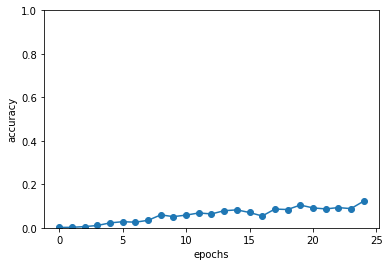

In [8]:
plt.plot(range(max_epoch), acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([0.0, 1.0])

### 7.4  seq2seq 개선

속도 개선

### 7.4.1 입력 데이터 반전(Reverse)

학습 진행이 빨라져, 최종 정확도도 좋아진다고 알려져 있다.

기울기 전파가 더 원활해지기 때문인 것으로 보인다. 입력 데이터의 앞 부분에 있는 문자(단어)는 역전파 때 먼 거리를 이동해서 기울기가 전파되지만 순서를 반전시키면 바로 기울기가 전파될 수 있기 때문에 기울기 전파가 더욱 원활해진다.

<img src="./images/fig%207-24.png" width=500>

### 7.4.2 엿보기(Peeky)

Encoder의 출력 벡터 h를 Decoder의 모든 계층에서 볼 수 있게 되면 중요한 정보를 모든 계층에서 공유할 수 있어 학습이 개선된다.

<img src="./images/fig%207-26.png" width=700>

LSTM 계층과 Affine 계층에 입력되는 벡터가 2개씩 있는데 실제는 concat 노드를 이용해서 표현하는 것이 더욱 정확하다.

In [9]:
class PeekyDecoder:
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None
        
        
    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape
        
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)
        
        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)
        
        score = self.affine.forward(out)
        self.cache = H
        
        return score

In [49]:
from seq2seq import Seq2seq, Encoder

class PeekySeq2seq(Seq2seq):
    
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

<img src="./images/fig%207-28.png" width=500>

정확도는 크게 개선되었지만 어텐션은 더욱 획기적인 개선을 기대할 수 있다. 주의할 점은 Peeky를 사용하면 가중치 매개변수가 커져서 계산량도 늘어난다. 또한 seq2seq의 정확도는 하이퍼파라미터에 영향을 크게 받는다.

## 7.5 seq2seq를 이용하는 애플리케이션

- 기계 번역
- 자동 요약
- 질의응답
- 메일 자동 응답

### 7.5.1 챗봇

상대의 말을 자신의 말로 변환하는 문제로 볼 수 있다.

### 7.5.2 알고리즘 학습

소스 코드를 원하는 답으로 변환시키는 문제에도 적용해 볼 수 있다.

### 7.5.2 이미지 캡셔닝

이미지를 문장으로 변환하는 기법

<img src="./images/fig%207-31.png" width=700>

Encoder를 합성곱 신경망으로 대체한 것이다. 대신 합성곱 신경망의 출력인 특징 맵을 사용하는 것이 아닌 평탄화된 데이터를 전달한다. CNN으로 이미 입증된 모델을 이용하고 